# bike_sharing_demand 회귀분석 프로젝트



**Data Fields**

- datetime : hourly date + timestamp  
- season :  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday : whether the day is considered a holiday
- workingday : whether the day is neither a weekend nor holiday
- weather : 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : temperature in Celsius
- atemp : "feels like" temperature in Celsius
- humidity : relative humidity
- windspeed : wind speed
- casual : number of non-registered user rentals initiated
- registered : number of registered user rentals initiated
- count : number of total rentals

https://www.kaggle.com/competitions/bike-sharing-demand/data?select=test.csv


# 데이터 불러오기 

In [79]:
# 필요한 라이브러리 
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats 

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline 

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname="c:/windows/fonts/malgun.ttf").get_name()
rc('font',family=font_name)

In [80]:
# train(학습) 데이터 불러오기 
train = pd.read_csv("c:/data/bike-sharing-demand/train.csv", parse_dates = ["datetime"])
train.shape

(10886, 12)

In [81]:
# test(예측) 데이터 
test = pd.read_csv("c:/data/bike-sharing-demand/test.csv", parse_dates = ['datetime'])
test.shape

(6493, 9)

In [82]:
# 컬럼 살펴보기 -- null값이 없고 각 컬럼 별 데이터 타입을 확인함. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [39]:
# train 데이터에서 5개만 보며 데이터 형태 파악하기 
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [40]:
# seasson, holiday, workingday, weather에서 이상치가 발견되지 않은 것을 파악함. 
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# 필요한 컬럼 추가하기 

In [83]:
# 분석 시 추가적으로 필요한 컬럼 추가하기 
train["year"] = train["datetime"].dt.year # 년도
train["month"] = train["datetime"].dt.month # 월별 
train["day"] = train["datetime"].dt.day # 일자
train["hour"]= train["datetime"].dt.hour # 시간
train['dayofweek'] = train['datetime'].dt.dayofweek # 요일 
train['year_month'] = train['year'].astype(str) + '-' + train['month'].astype(str)

train.shape

(10886, 18)

In [84]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test['year_month'] = test['year'].astype(str) + '-' + test['month'].astype(str)


test.shape

(6493, 15)

In [43]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5,2011-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5,2011-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5,2011-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5,2011-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5,2011-1


In [44]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,year_month
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3,2011-1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3,2011-1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3,2011-1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,2011-1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3,2011-1


In [45]:
# holiday도 아니고 workingday도 아닌 경우는 무슨 경우지? 그리고 windspeed가 0인 경우는 뭐지? 

train[(train['holiday'] == 0) & (train['workingday'] == 0)].head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5,2011-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5,2011-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5,2011-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5,2011-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5,2011-1


In [46]:
# 혹시나 비는 월이 없는 확인 
train["datetime"].dt.strftime("%Y-%m").unique() #1~12월 값이 잘 들어간 것을 확인할 수 있었음

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12'],
      dtype=object)

In [47]:
test["datetime"].dt.strftime("%Y-%m").unique() #1~12월 값이 잘 들어간 것을 확인할 수 있었음

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12'],
      dtype=object)

In [48]:
# holiday도 아니고 workingday에도 속하지 않는 데이터를 처리하기 

train[(train['holiday'] == 0) & (train['workingday'] == 0) & (train['dayofweek'].isin([5,6]))] # 토,일 데이터만 해당 경우가 발생한 것을 파악할 수 있었다.
train.loc[(train['holiday'] == 0) & (train['workingday'] == 0) & (train['dayofweek'].isin([5, 6])), 'workingday'] = 1 # 해당 경우를 만족하는 경우 workingday의 행 값을 1로 변경하는 코드를 짜줬다. 

test[(test['holiday'] == 0) & (test['workingday'] == 0) & (test['dayofweek'].isin([5,6]))] # 토,일 데이터만 해당 경우가 발생한 것을 파악할 수 있었다.
test.loc[(test['holiday'] == 0) & (test['workingday'] == 0) & (test['dayofweek'].isin([5, 6])), 'workingday'] = 1 # 해당 경우를 만족하는 경우 workingday의 행 값을 1로 변경하는 코드를 짜줬다. 

# 시각화 EDA 

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '연월별 대여량')]

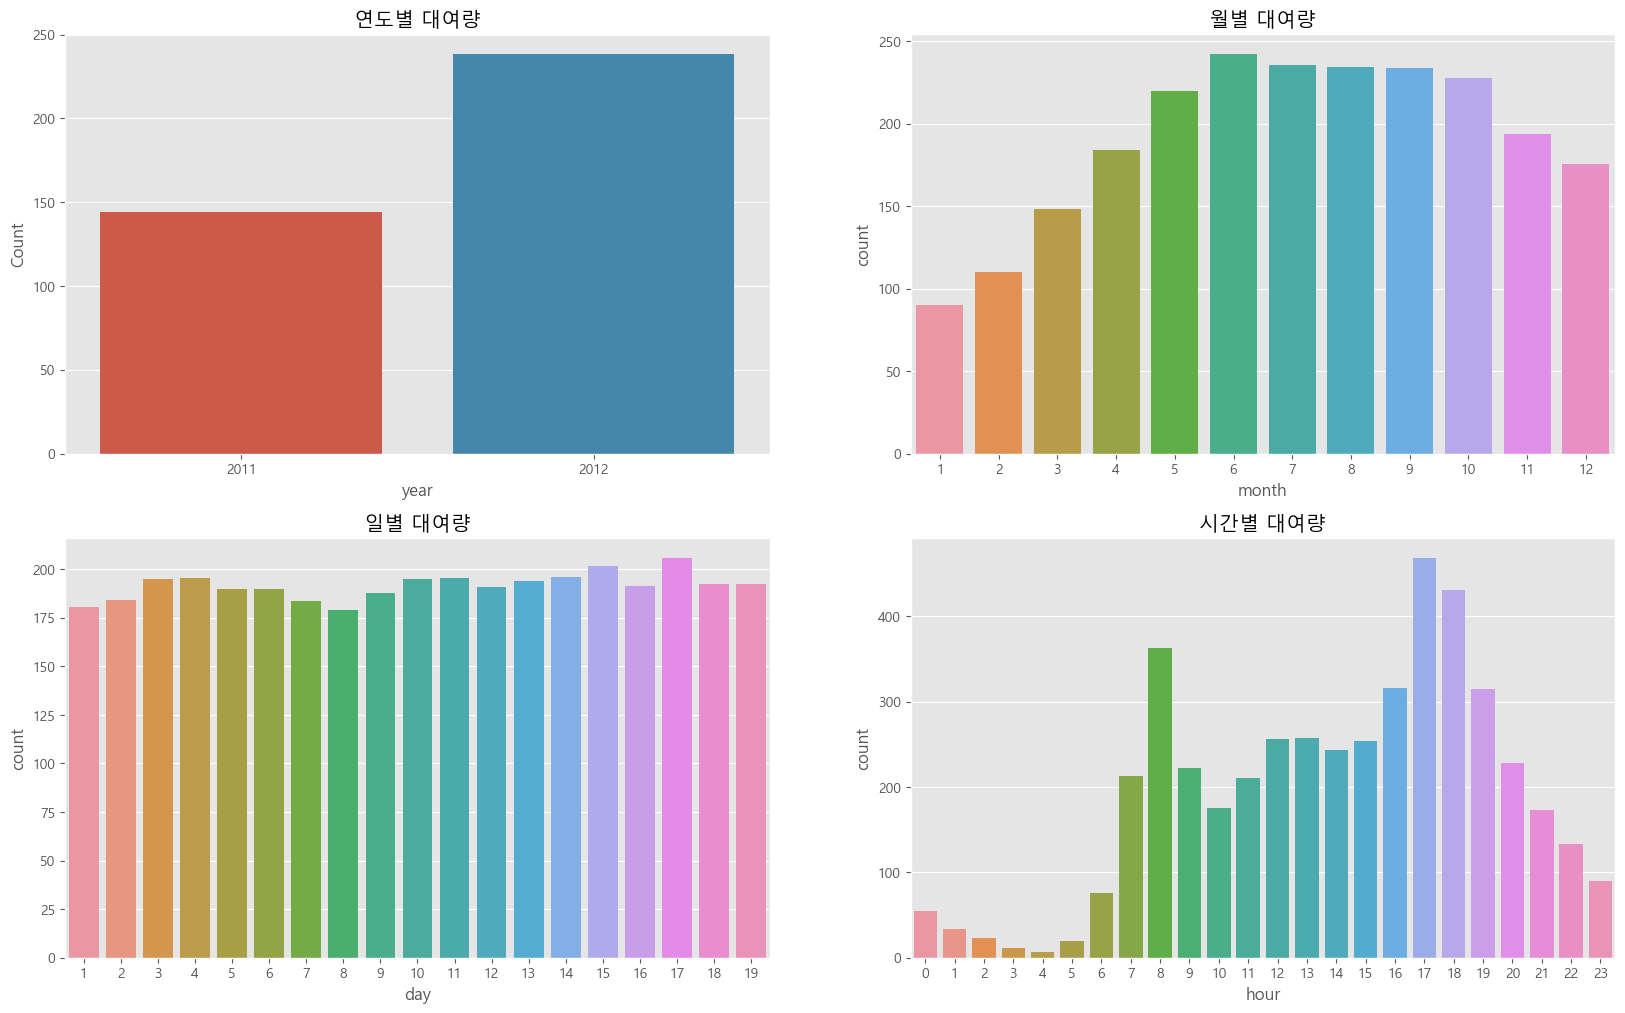

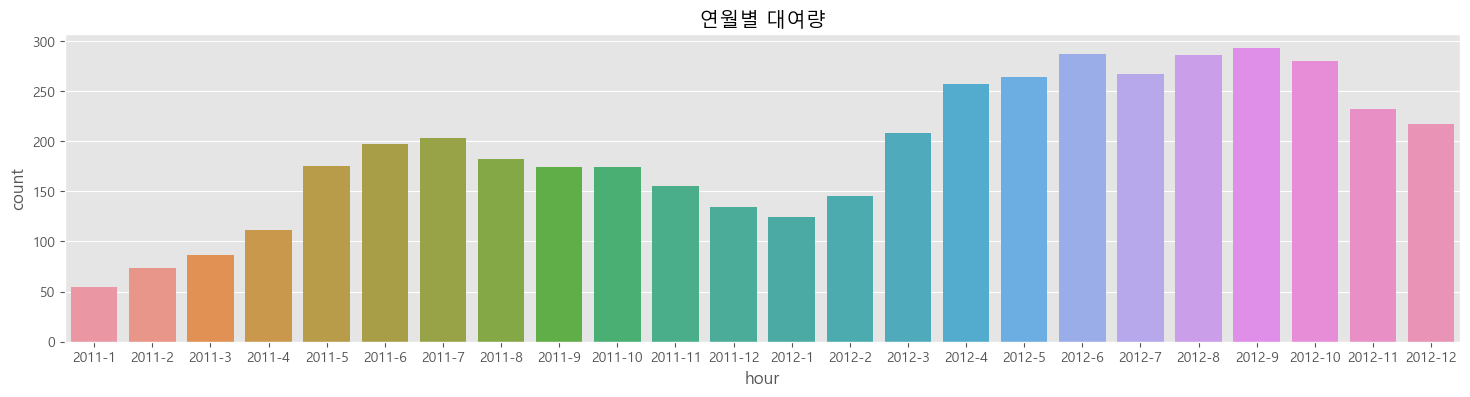

In [85]:
# 시각화 하기

figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(20,12)

sns.barplot(data=train, x = "year", y = "count", ax = ax1, errorbar = ('ci', False)) # 신뢰구간 없애기 
sns.barplot(data=train, x = "month", y = "count", ax = ax2, errorbar = ('ci',False))
sns.barplot(data=train, x = "day", y = "count", ax = ax3, errorbar = ('ci',False))
sns.barplot(data=train, x = "hour", y = "count", ax = ax4, errorbar = ('ci',False))

ax1.set(ylabel = "Count", title = "연도별 대여량")
ax2.set(xlabel = "month", title = "월별 대여량")
ax3.set(xlabel = "day", title = "일별 대여량")
ax4.set(xlabel = "hour", title = "시간별 대여량")


fig, ax5 = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(18,4)

sns.barplot(data = train, x = "year_month", y = 'count', ax = ax5, errorbar = ('ci',False))

ax5.set(xlabel = "hour", title = "연월별 대여량")


- 연도별 대여량은 2011년보다 2012년이 더 많다
- 월별 대여량은 1월이 가장 작고 6월이 가장 많았다.
- 일별 대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용할 수 없다.
- 시간대 대여량을 보면 출퇴근 시간에 대여량이 많다. 하지만 주말과 나누어 볼 필요가 있는 것 같다. 

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

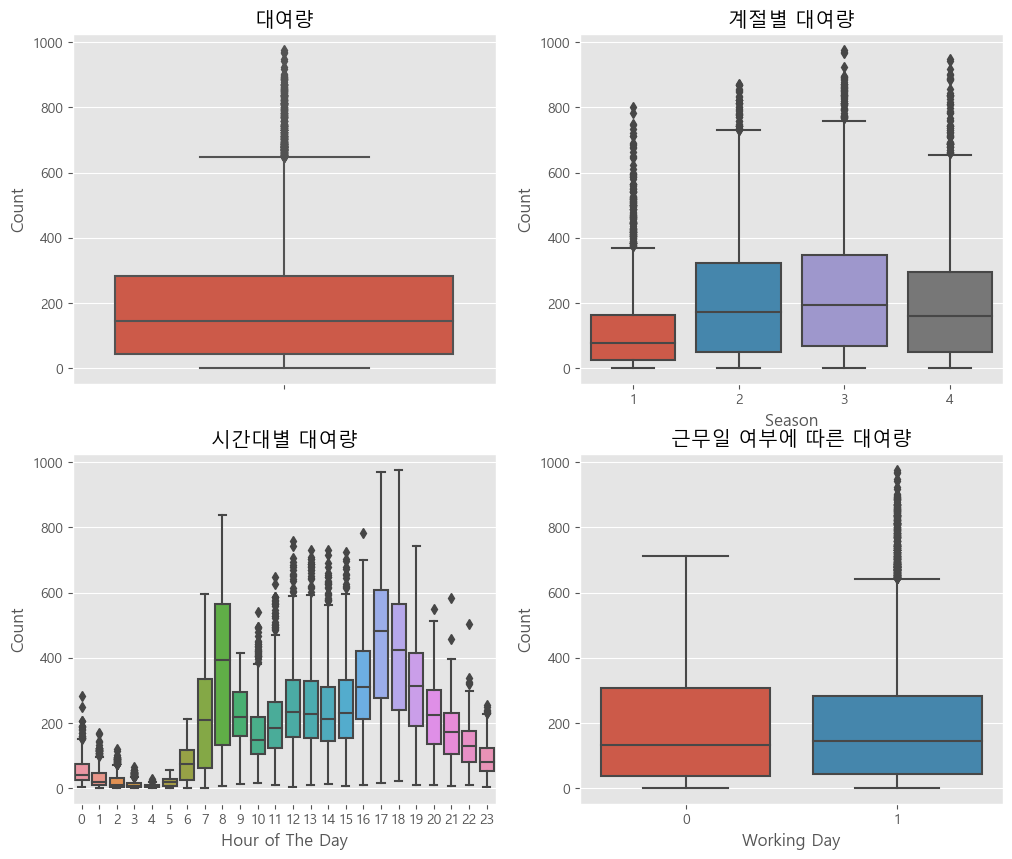

In [50]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12,10)

sns.boxplot(data=train, y='count', orient = 'v', ax=axes[0][0])
sns.boxplot(data=train, y='count', x = 'season',orient = 'v', ax=axes[0][1])
sns.boxplot(data=train, y='count', x = 'hour', orient = 'v', ax=axes[1][0])
sns.boxplot(data=train, y='count', x = 'workingday', orient = 'v', ax=axes[1][1])

axes[0][0].set(ylabel = 'Count', title = "대여량")
axes[0][1].set(xlabel = 'Season', ylabel = 'Count', title = "계절별 대여량")
axes[1][0].set(xlabel = 'Hour of The Day', ylabel = 'Count', title = "시간대별 대여량")
axes[1][1].set(xlabel = 'Working Day', ylabel = 'Count', title = "근무일 여부에 따른 대여량")


- 봄에 가장 대여량이 낮고, 가을이 가장 많았다. 
- 시간대별 대여량은 앞서 그린 barplot과 비슷한 추세를 보였다.
- working day가 아닌, holiday때 대여값이 더 많았다. (?)

<AxesSubplot: xlabel='hour', ylabel='count'>

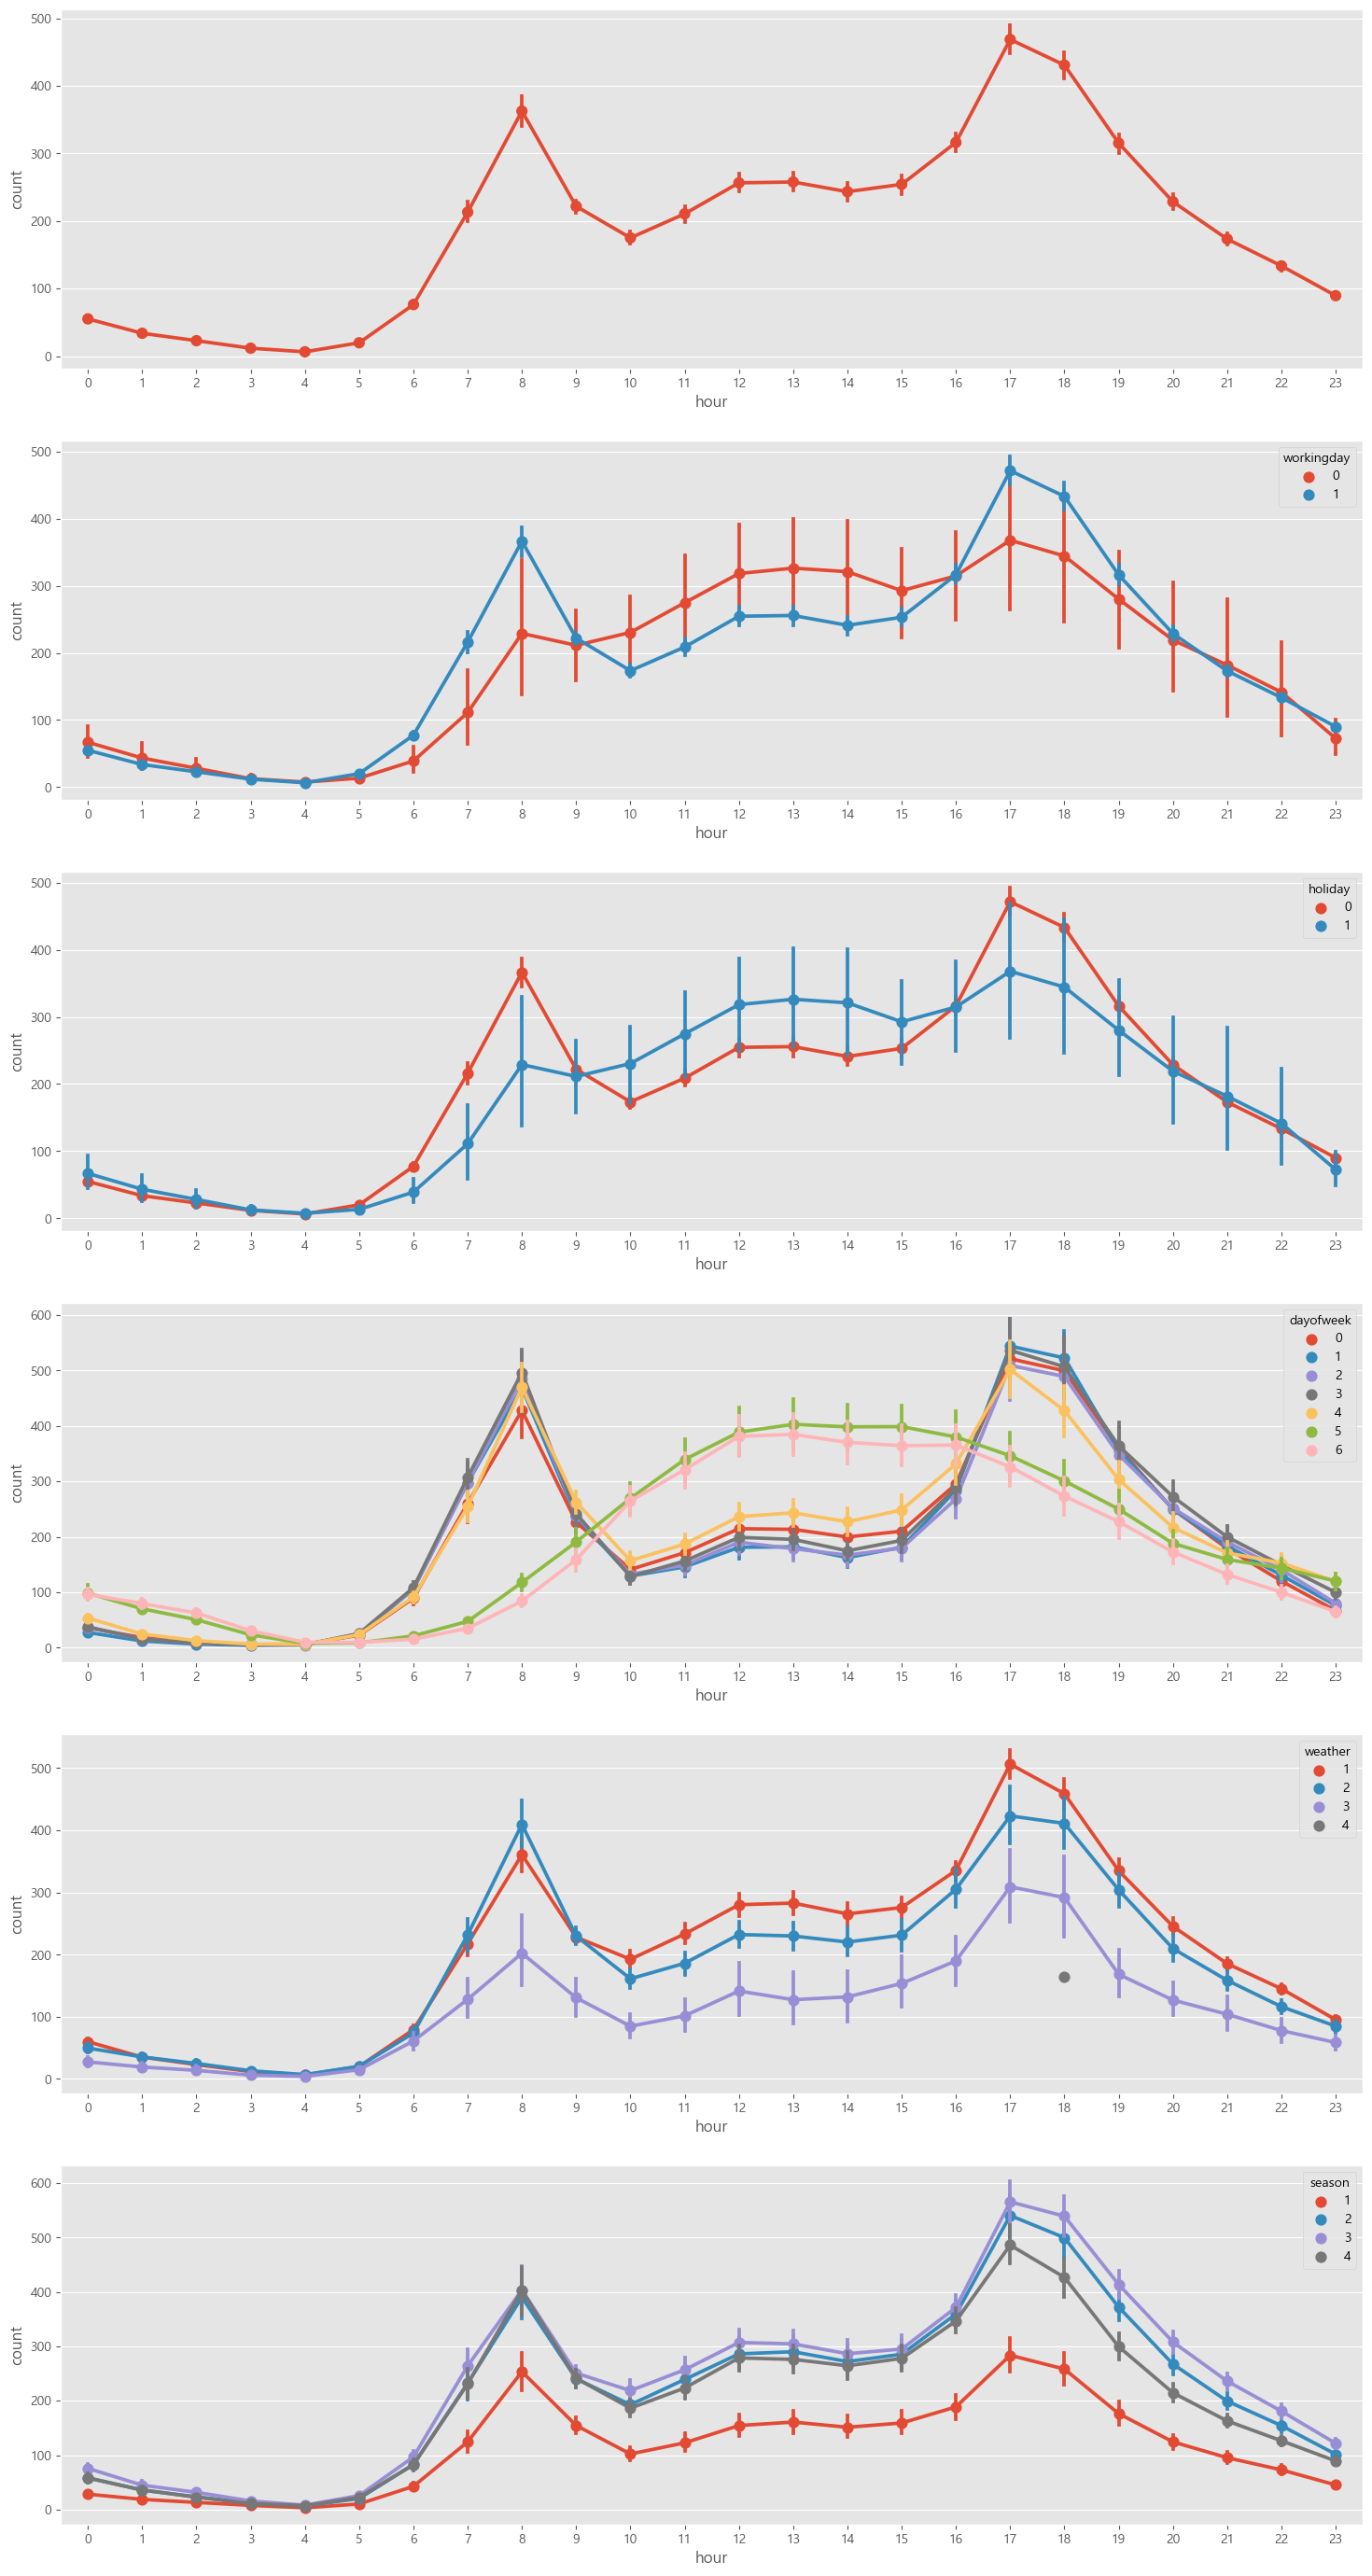

In [51]:
fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(nrows = 6)
fig.set_size_inches(18,35)

sns.pointplot(data= train, x= 'hour', y= 'count', ax= ax1)
sns.pointplot(data= train, x= 'hour', y= 'count', hue = 'workingday', ax= ax2)
sns.pointplot(data= train, x= 'hour', y= 'count', hue = 'holiday', ax= ax3)
sns.pointplot(data= train, x= 'hour', y= 'count', hue = 'dayofweek', ax= ax4)
sns.pointplot(data= train, x= 'hour', y= 'count', hue = 'weather', ax= ax5)
sns.pointplot(data= train, x= 'hour', y= 'count', hue = 'season', ax= ax6)

- [시간] 시간대별로 보았을 때 출퇴근 시간인 8시와 17시 시간대에 자전거 수요량이 급상승 하는 것을 파악할 수 있다. 
- [workingday] 근무일에는 출퇴근 시간대에 자전거 수요량이 집중되어 있고, 근무일이 아닐 때는 오후 시간대로 갈 수록 수요량이 커지는 것을 확인할 수 있다. 
- [dayofweek] 주중은 workingday 1일때와 비슷하고 주말은 workingday 0일때와 비슷하다 
- [weather] 1,2번날씨 > 3번날씨 > 4번날씨는 데이터가 거의 없음
- [season] 봄에 대여량이 가장 낮았고, 가을에 대여량이 가장 많았다. 가을 > 여름 > 겨울 > 봄 

In [52]:
# 변수간 상관관계 알아보기

corrMatt = train[['temp','atemp','casual','registered','humidity','windspeed','count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot: >

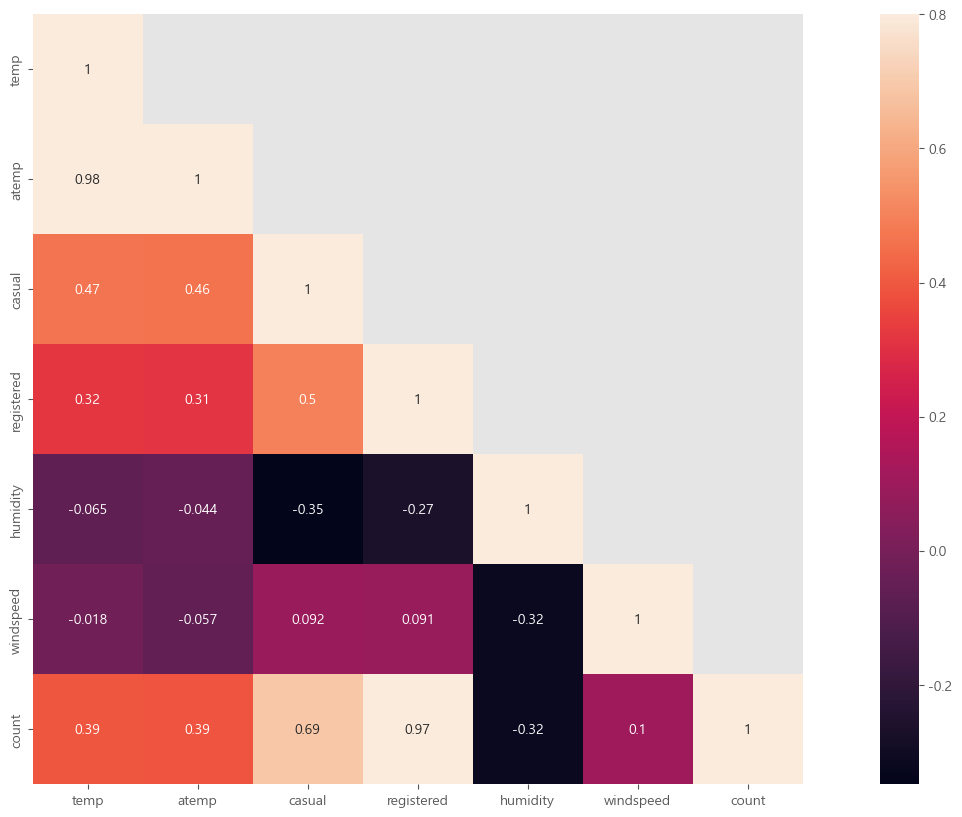

In [53]:
# heatmap 으로 그려보기 
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask= mask, vmax = .8, square= True, annot= True)

- 온도, 습도, 풍속은 대여량과 연관관계거 거의 없다 
- 대여량과 가장 연관관계가 높은건 registered로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다.

- temp와 atemp의 상관관계가 무척 높게 나와서 다중 공선성이 의심된다.

<AxesSubplot: xlabel='windspeed', ylabel='count'>

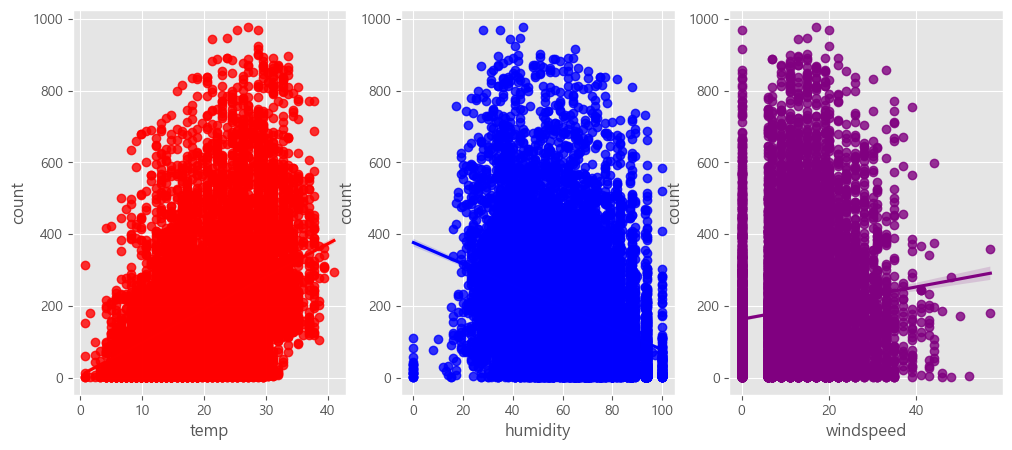

In [54]:
# 산점도 그려보기

fig,(ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12,5)
sns.regplot(x = 'temp', y = 'count', data = train, ax = ax1, color = 'red')
sns.regplot(x = 'humidity', y = 'count', data = train, ax = ax2, color = 'blue')
sns.regplot(x = 'windspeed', y = 'count', data = train, ax = ax3, color = 'purple')

- 풍속의 경우 0에 숫자가 몰려있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해본다
- feature engineering을 통해 조정을 해야할 것으로 보인다. 

- 2011년보다 2012년의 대여량이 많다.
- 2011년과 2012의 년월 데이터로 봤을 때 전체적으로 서비스 사용자 수가 증가하는 추세이다. 

[Text(0, 0.5, 'count')]

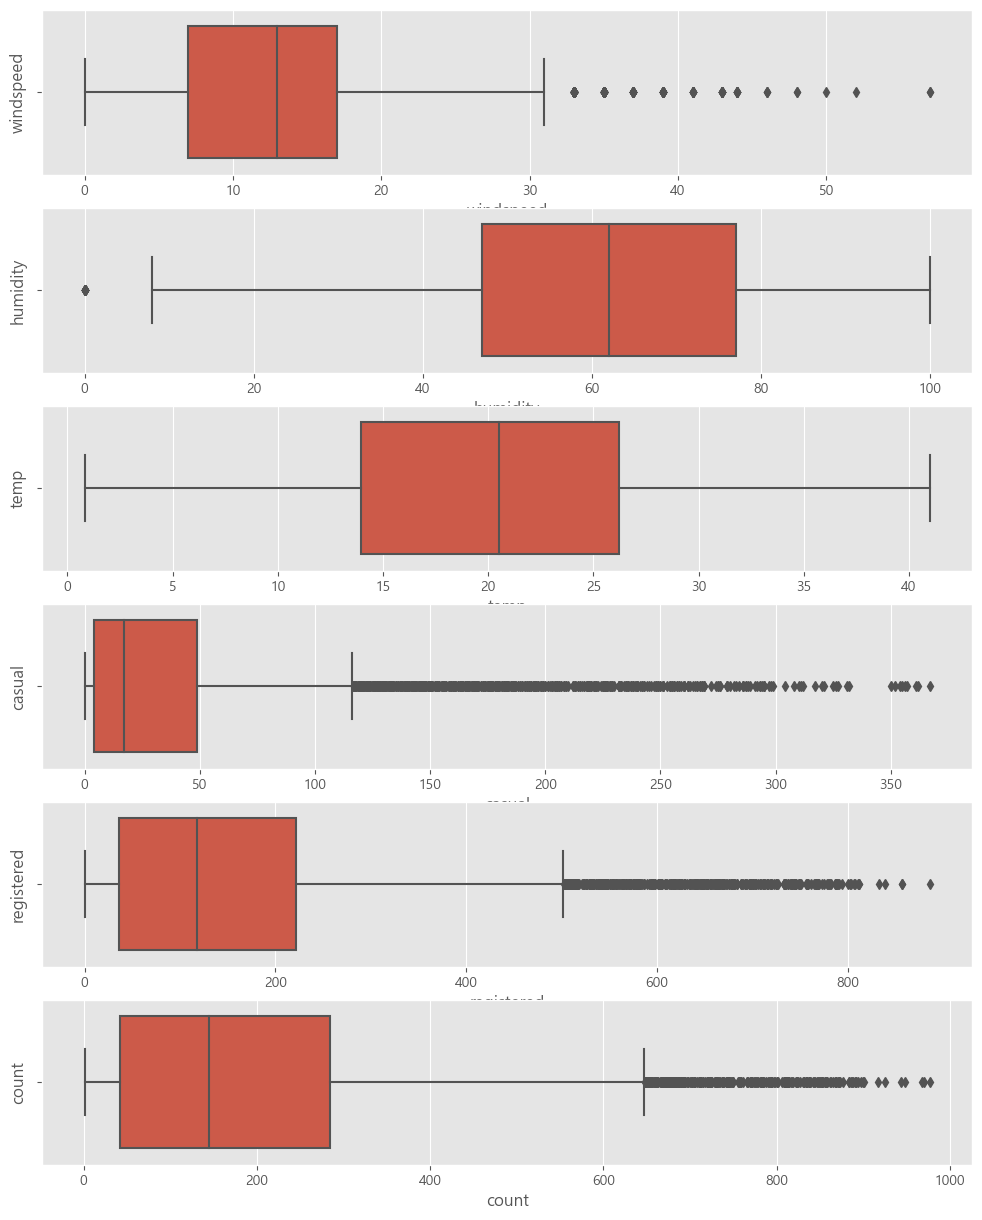

In [55]:
# 이상치 제거를 위한 연속형 변수 box plot 작성 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12,15))

sns.boxplot(data = train, x = 'windspeed', ax = ax1)
sns.boxplot(data = train, x = 'humidity', ax = ax2)
sns.boxplot(data = train, x = 'temp', ax = ax3)
sns.boxplot(data = train, x = 'casual', ax = ax4)
sns.boxplot(data = train, x = 'registered', ax = ax5)
sns.boxplot(data = train, x = 'count', ax = ax6)

ax1.set(ylabel = 'windspeed')
ax2.set(ylabel = 'humidity')
ax3.set(ylabel = 'temp')
ax4.set(ylabel = 'casual')
ax5.set(ylabel = 'registered')
ax6.set(ylabel = 'count')

In [86]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 18)
(10739, 18)


C:\Users\82108\AppData\Local\Temp\ipykernel_25968\339290883.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["count"], ax=axes[0][0])
C:\Users\82108\AppData\Local\Temp\ipykernel_25968\339290883.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(trainWithoutOutliers["count"]), ax

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229785, 4.562423868087808, 0.9581176780909617))

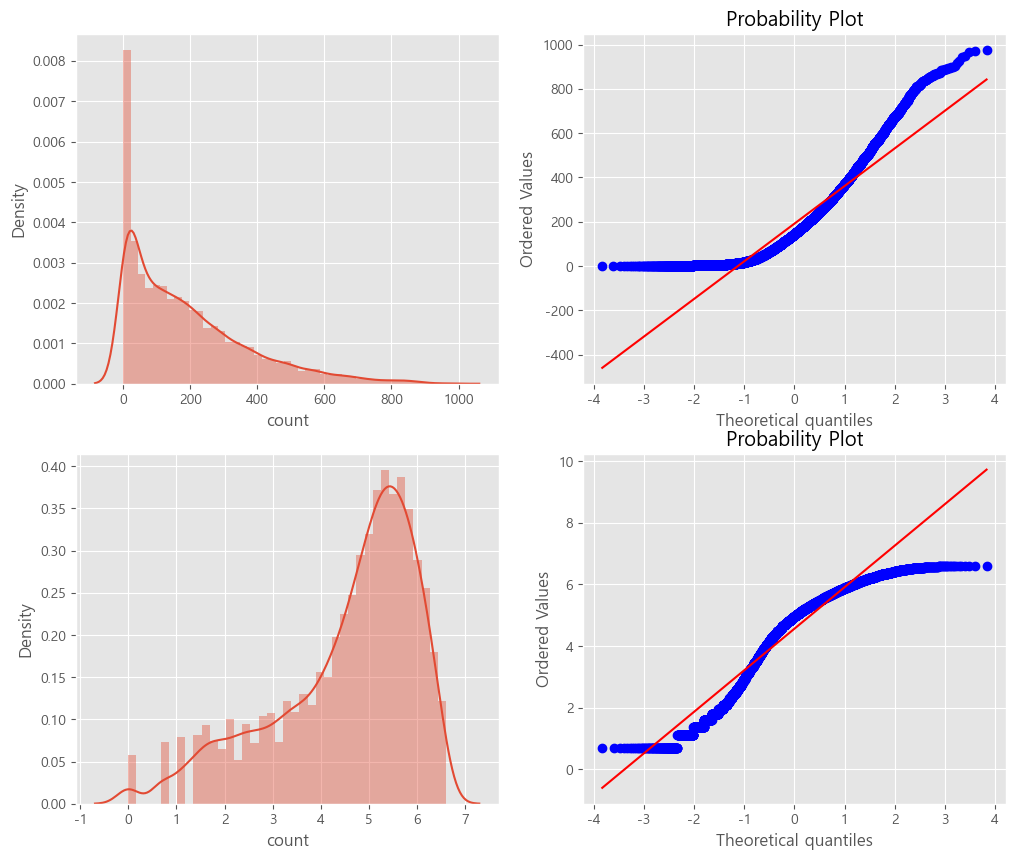

In [57]:
from scipy import stats

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

- count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

In [87]:
train = trainWithoutOutliers

# feature engineering 

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1, random_state = 123)
train_temp = pca.fit_transform(train[['temp','atemp']])
test_temp = pca.transform(test[['temp','atemp']])

# 검증코드 
assert train_temp[10].round(3) == 6.063
assert test_temp[10].round(3) == 15.526

AssertionError: 

In [89]:
# temp, atemp 컬럼을 제거한 후 'temp_pca' 컬럼을 생성하여 train_temp, test_temp를 대입합니다.
# train, test 데이터 셋 모두 적용

train = train.drop(['temp','atemp'],axis = 1)
test = test.drop(['temp','atemp'], axis = 1)

train['temp_pca'] = train_temp
test['temp_pca'] = test_temp

In [61]:
# 잘 들어갔는지 확인하기 
train.head()

,datetime,season,holiday,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,year_month,temp_pca
0,2011-01-01 00:00:00,1,0,1,1,81,0.0,3,13,16,2011,1,1,0,5,2011-1,13.702227
1,2011-01-01 01:00:00,1,0,1,1,80,0.0,8,32,40,2011,1,1,1,5,2011-1,14.816616
2,2011-01-01 02:00:00,1,0,1,1,80,0.0,5,27,32,2011,1,1,2,5,2011-1,14.816616
3,2011-01-01 03:00:00,1,0,1,1,75,0.0,3,10,13,2011,1,1,3,5,2011-1,13.702227
4,2011-01-01 04:00:00,1,0,1,1,75,0.0,0,1,1,2011,1,1,4,5,2011-1,13.702227


<AxesSubplot: title={'center': 'test windspeed'}, xlabel='windspeed', ylabel='count'>

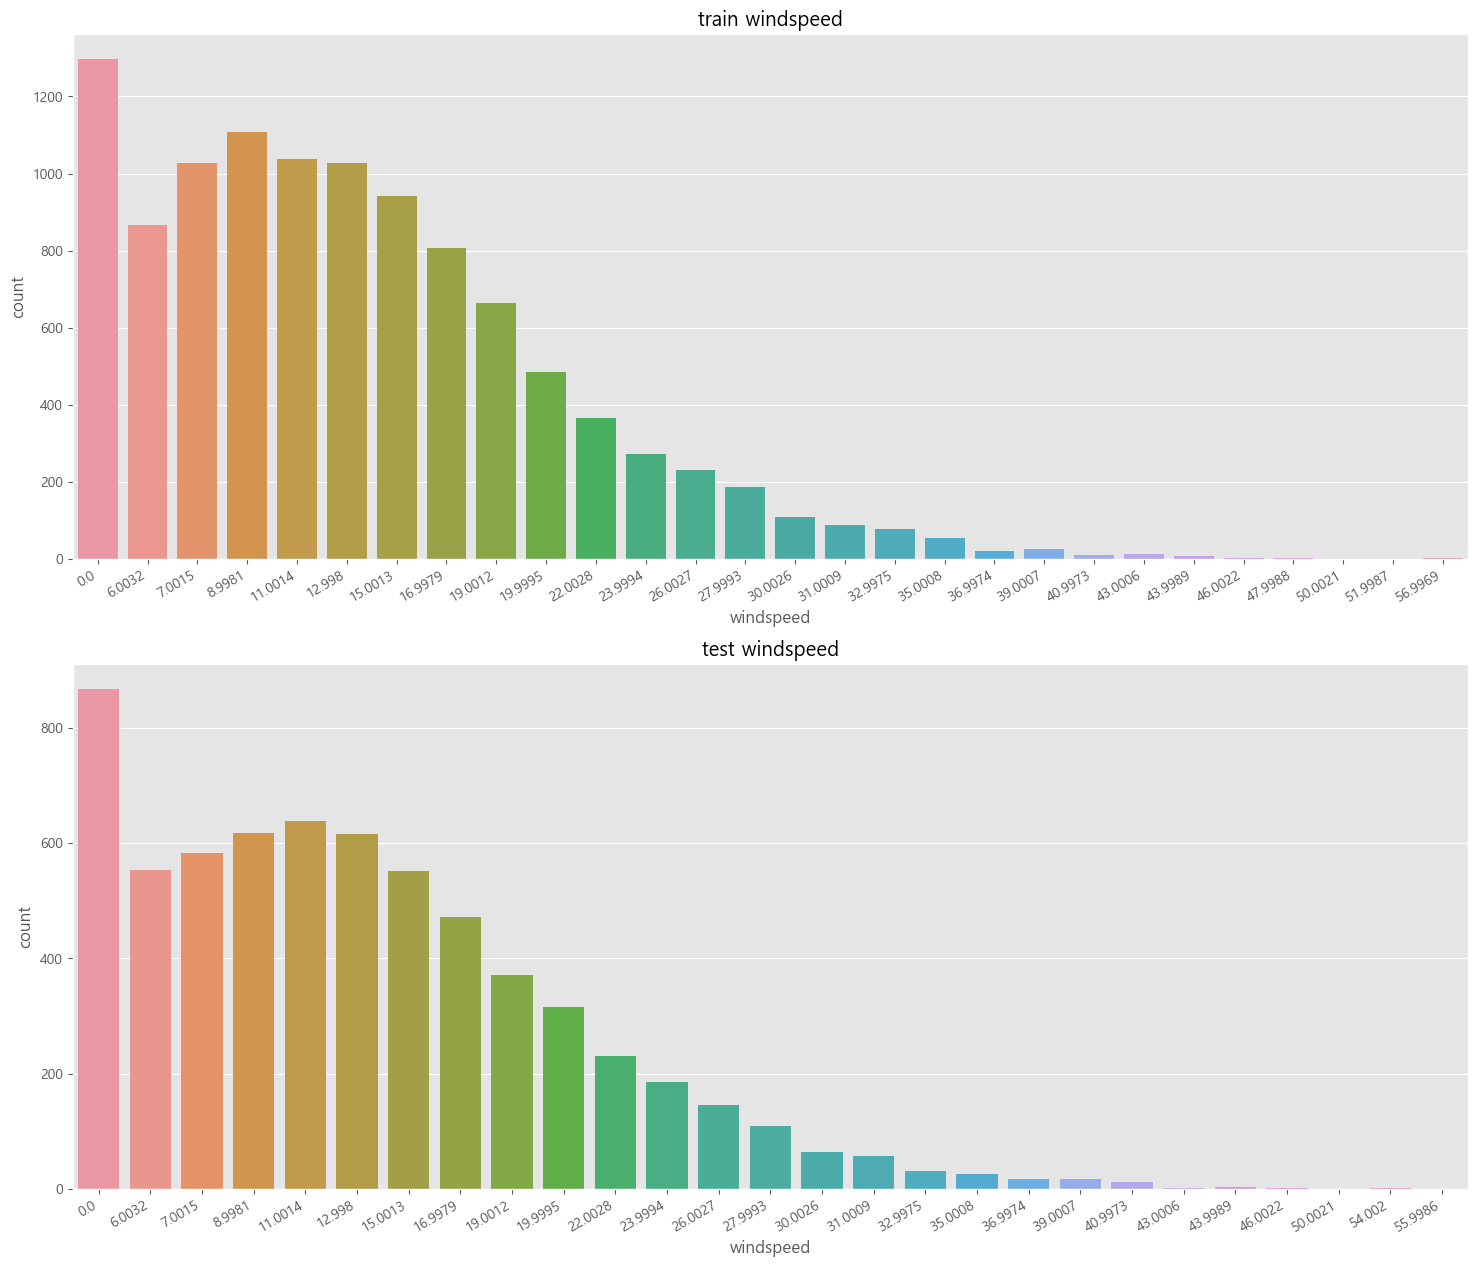

In [90]:
# 풍속 0값 수정하기 

fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,15)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [91]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "year", "temp_pca"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [92]:
# 0값을 조정한다.
train = predict_windspeed(train)
test = predict_windspeed(test)

C:\Users\82108\AppData\Local\Temp\ipykernel_25968\3454363719.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
C:\Users\82108\AppData\Local\Temp\ipykernel_25968\3454363719.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictWind0["windspeed"] = wind0Values
C:\Users\82108\AppData\Local\Temp\ipykernel_25968\3454363719.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [93]:
# 0값이 잘 사라진 것을 확인할 수 있었다. 

train[train['windspeed'] == 0]

,datetime,season,holiday,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,year_month,temp_pca


<AxesSubplot: title={'center': 'train windspeed'}, xlabel='windspeed', ylabel='count'>

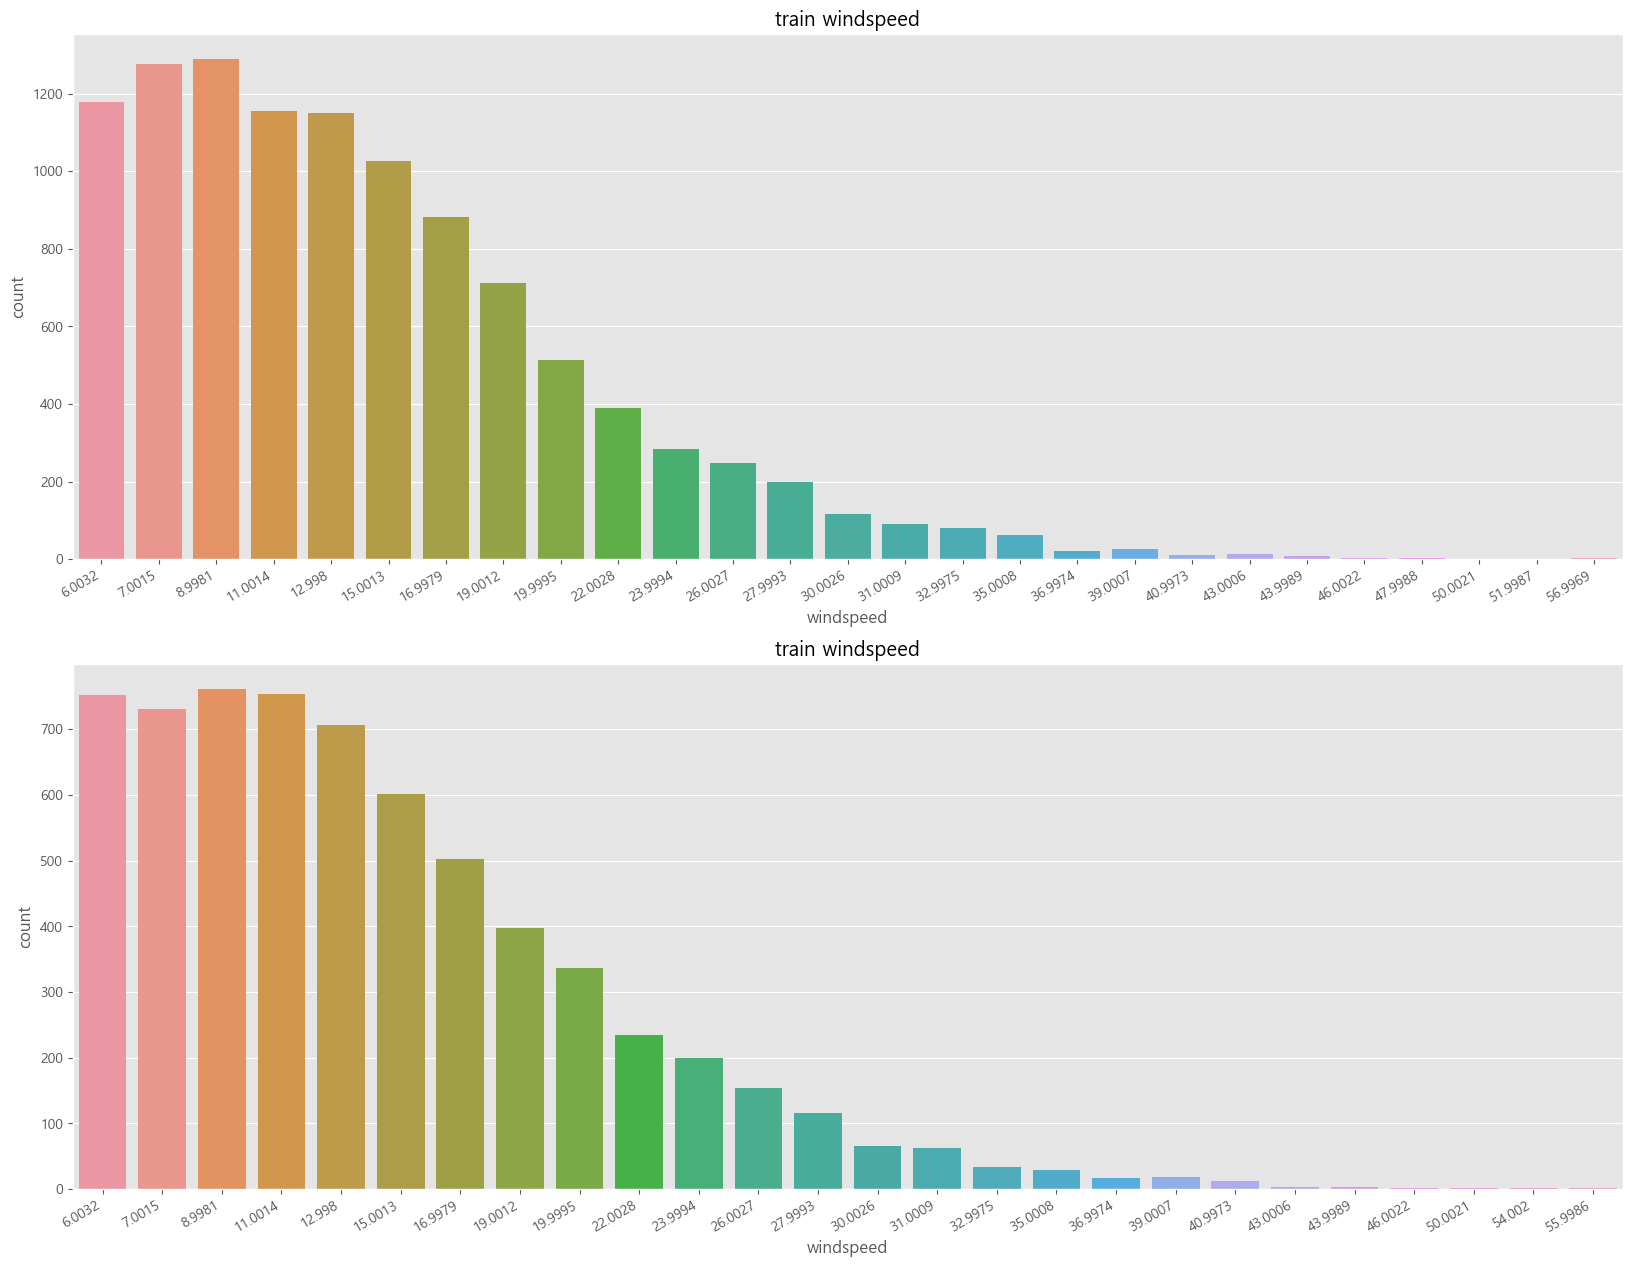

In [66]:
# widspeed 의 0값을 조정한 데이터를 시각화
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(20,15)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data = train, x = 'windspeed', ax = ax1)

plt.sca(ax2)
plt.xticks(rotation=30, ha='right')
ax2.set(ylabel='Count',title="train windspeed")
sns.countplot(data = test, x = 'windspeed', ax = ax2)


# Feature Selection

좋은 예측에 필요한 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거해보자. 

연속형 피처는 온도, 습도, 풍속은 숫자의 크기에 따라 높고 낮음을 알 수 있지만, 범주형 피처는 요일,계절등을 0,1,2,3으로 나타낸 것이기 때문에 원-핫 코딩으로 바꿔줄 필요가 있다. 

여기서는 범주형 피처를 카테고리를 통해 바꾸어 보자.

 
- 연속형 피처 = temp,humidity,windspeed,atemp
- 범주형 피처 = season,holiday,workingday,weather,dayofweek,month,year,hour

In [94]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour","year_month"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [106]:
# 변수간 상관관계 알아보기

corrMatt = train[['temp_pca','casual','registered','humidity','windspeed','count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

            temp_pca    casual  registered  humidity  windspeed     count
temp_pca    1.000000 -0.460044   -0.303677  0.045207   0.035341 -0.385204
casual     -0.460044  1.000000    0.498085 -0.341204   0.101787  0.704764
registered -0.303677  0.498085    1.000000 -0.263525   0.091889  0.966209
humidity    0.045207 -0.341204   -0.263525  1.000000  -0.345310 -0.317028
windspeed   0.035341  0.101787    0.091889 -0.345310   1.000000  0.105435
count      -0.385204  0.704764    0.966209 -0.317028   0.105435  1.000000


<AxesSubplot: >

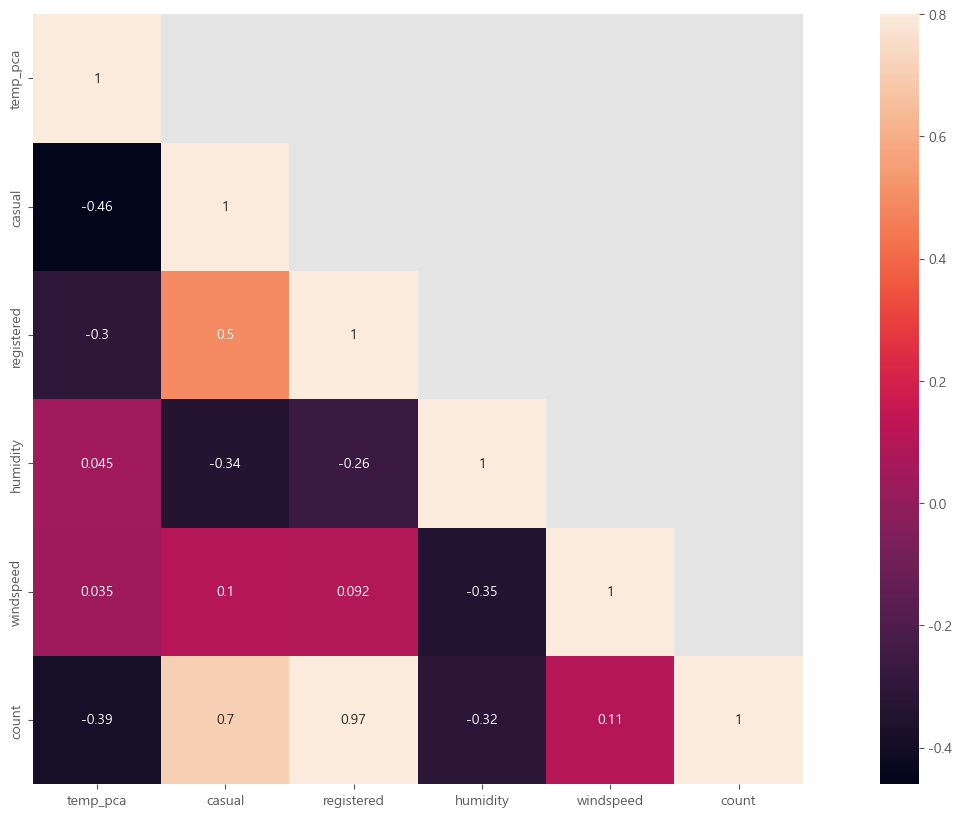

In [107]:
# heatmap 으로 그려보기 
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask= mask, vmax = .8, square= True, annot= True)

In [108]:
# modeling에 사용될 컬럼만 추려주기
feature_names = ["season", "weather", "temp_pca", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp_pca',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [109]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10739, 9)


,season,weather,temp_pca,humidity,year,hour,dayofweek,holiday,workingday
0,1,2,14.818368,75,2011,5,5,0,0
1,1,1,5.916242,76,2011,10,5,0,0
2,1,1,8.703000,81,2011,11,5,0,0
3,1,1,3.691148,77,2011,12,5,0,0
4,1,2,1.466054,72,2011,13,5,0,0


In [110]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 9)


,season,weather,temp_pca,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,15.380033,56,2011,0,3,0,1
1,1,1,14.263892,56,2011,3,3,0,1
2,1,1,14.263892,56,2011,4,3,0,1
3,1,1,15.934509,60,2011,5,3,0,1
4,1,1,17.048898,60,2011,6,3,0,1


In [114]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10739,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Random Forest

## RMLSE

과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

In [120]:
# RMLSE 

from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp = True):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation 교차검증

- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.


- KFold 교차검증
    - 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
    - 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
    - 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
    - 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
    - 이 과정을 마지막 폴드까지 반복한다.
    - 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [116]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## 랜덤 포레스트 

In [117]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [118]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: total: 4.31 s
Wall time: 6.67 s
Score= 0.33010


In [76]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [77]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.42,   3.65,   3.18,   6.09,  37.16, 102.1 , 238.47, 138.82,
        59.81,  60.66])

C:\Users\82108\AppData\Local\Temp\ipykernel_25968\1943322882.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,ax=ax1,bins=50)
C:\Users\82108\AppData\Local\Temp\ipykernel_25968\1943322882.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions,ax=ax2,bins=50)


[Text(0.5, 1.0, 'test')]

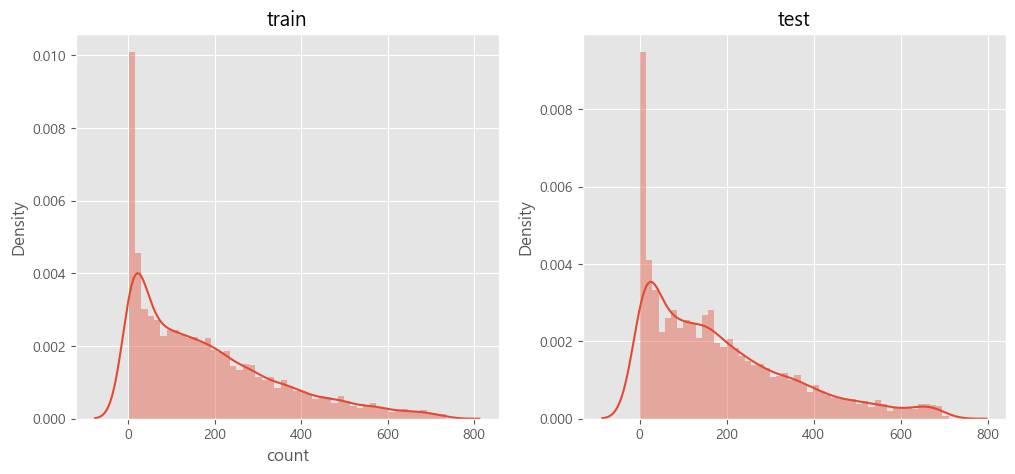

In [78]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## Linear Regression Model 

In [121]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
import warnings 
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)

# 선형 회귀 모델 초기화
lModel = LinearRegression()

# 모델 학습 
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도 평가 
predicts = lModel.predict(X_train)
print('RMSLE Value For Linear Regression: ', 
     rmsle(np.exp(y_train_log), np.exp(predicts),False))

RMSLE Value For Linear Regression:  0.9795194166680928


## Ridge 모델 

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9795194143966022


<AxesSubplot: xlabel='alpha', ylabel='rmsle'>

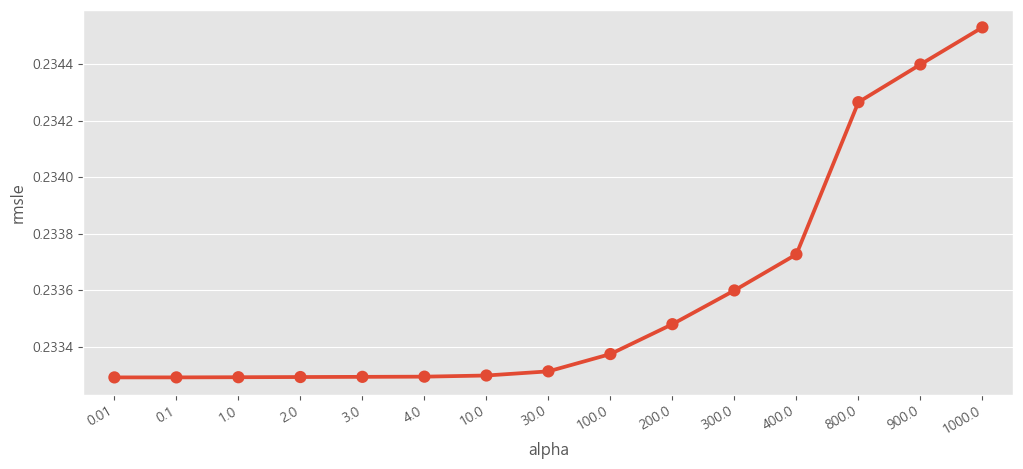

In [122]:
ridge_m_ = Ridge()

ridge_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.1, 1,2,3,4,10,30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV(ridge_m_,
                            ridge_params_,
                           scoring = rmsle_scorer,
                           cv = 5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)

print(grid_ridge_m.best_params_)
print('RMSLE Value For Ridge Regression: ', 
     rmsle(np.exp(y_train_log), np.exp(preds),False))


fig,ax = plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df['params'].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Lasso 

In [123]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9795149880167047


,alpha,rmsle
0,10.000000,0.315613
1,1.000000,0.249278
2,0.500000,0.245451
3,0.333333,0.244367
4,0.250000,0.243861


<AxesSubplot: xlabel='alpha', ylabel='rmsle'>

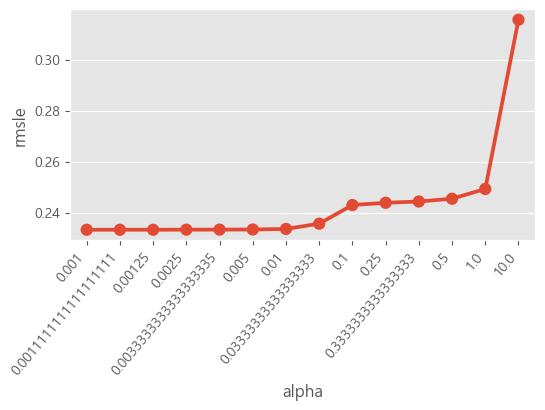

In [124]:
fig,ax= plt.subplots()
fig.set_size_inches(6,3)
plt.xticks(rotation=50, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Gradient Boost 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

In [ ]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)